In [9]:
import os
import requests
import gzip
from io import BytesIO
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import csv
import math

# Function to calculate GC1, GC2, GC3
def calculate_codon_gc(sequence):
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    gc1 = gc_fraction("".join(codons[::3])) * 100
    gc2 = gc_fraction("".join(codons[1::3])) * 100
    gc3 = gc_fraction("".join(codons[2::3])) * 100
    return gc1, gc2, gc3

# Function to calculate ENc
def calculate_enc(sequence):
    codon_count = {}
    total_codons = len(sequence) // 3

    for i in range(0, len(sequence) - 3, 3):
        codon = sequence[i:i + 3]
        if codon in codon_count:
            codon_count[codon] += 1
        else:
            codon_count[codon] = 1

    f_values = list(codon_count.values())
    f_sum = sum(f_values)
    f_sum_squared = sum([x * x for x in f_values])

    if f_sum > 1:
        en_c = 2 / ((total_codons - 1) * (1 / f_sum_squared))
    else:
        en_c = math.nan

    return en_c

# Download and unzip function
def download_and_unzip(url, output_directory):
    response = requests.get(url)
    if response.status_code == 200:
        # Get the file name from the URL
        file_name = url.split('/')[-1]
        file_path = os.path.join(output_directory, file_name.replace('.gz', ''))

        # Write the decompressed data to a file
        with gzip.open(BytesIO(response.content), 'rb') as f_in, open(file_path, 'wb') as f_out:
            f_out.write(f_in.read())

        return file_path
    else:
        print(f"Failed to download {url}")
        return None

def parse_fasta_file(input_file_path, output_file_path, organism_group, organism):
    with open(output_file_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['cds ID', 'cds length', 'Organism', 'Organism Group', 'GC%', 'ENc', 'GC1', 'GC2', 'GC3'])

        with open(input_file_path, "r") as handle:
            records = SeqIO.parse(handle, "fasta")
            for record in records:
                cds_id = record.id.split()[0]  # Extracting the ID
                cds_length = len(record.seq)
                gc_percent = gc_fraction(str(record.seq)) * 100
                enc_score = calculate_enc(str(record.seq))
                gc1, gc2, gc3 = calculate_codon_gc(str(record.seq))

                writer.writerow([cds_id, cds_length, organism, organism_group, gc_percent, enc_score, gc1, gc2, gc3])

organism_data = [
    ('Mammalia', 'Pongo_abelii', 'https://ftp.ensembl.org/pub/release-108/fasta/pongo_abelii/cds/Pongo_abelii.Susie_PABv2.cds.all.fa.gz'),
    ('Mammalia', 'Sarcophilus_harrisii', 'https://ftp.ensembl.org/pub/release-108/fasta/sarcophilus_harrisii/cds/Sarcophilus_harrisii.mSarHar1.11.cds.all.fa.gz'),
    ('Mammalia', 'Ornithorthynchus_anatinus', 'https://ftp.ensembl.org/pub/release-108/fasta/ornithorhynchus_anatinus/cds/Ornithorhynchus_anatinus.mOrnAna1.p.v1.cds.all.fa.gz'),
    ('Mammalia', 'Ursus_maritimus', 'https://ftp.ensembl.org/pub/release-108/fasta/ursus_maritimus/cds/Ursus_maritimus.UrsMar_1.0.cds.all.fa.gz'),
    ('Mammalia', 'Rattus_norvegicus', 'https://ftp.ensembl.org/pub/release-108/fasta/rattus_norvegicus/cds/Rattus_norvegicus.mRatBN7.2.cds.all.fa.gz'),
    ('Aves', 'Apteryx_haastii', 'https://ftp.ensembl.org/pub/release-108/fasta/apteryx_haastii/cds/Apteryx_haastii.aptHaa1.cds.all.fa.gz'),
    ('Aves', 'Parus_major', 'https://ftp.ensembl.org/pub/release-108/fasta/parus_major/cds/Parus_major.Parus_major1.1.cds.all.fa.gz'),
    ('Aves', 'Otus_sunia', 'https://ftp.ensembl.org/pub/release-108/fasta/otus_sunia/cds/Otus_sunia.OtuSun1.0.cds.all.fa.gz'),
    ('Aves', 'Anas_platyrhynchos', 'https://ftp.ensembl.org/pub/release-108/fasta/anas_platyrhynchos/cds/Anas_platyrhynchos.ASM874695v1.cds.all.fa.gz'),
    ('Aves', 'Numida_meleagris', 'https://ftp.ensembl.org/pub/release-108/fasta/numida_meleagris/cds/Numida_meleagris.NumMel1.0.cds.all.fa.gz'),
    ('Osteichthyes', 'Anabas_testudineous', 'https://ftp.ensembl.org/pub/release-108/fasta/anabas_testudineus/cds/Anabas_testudineus.fAnaTes1.2.cds.all.fa.gz'),
    ('Osteichthyes', 'Cyprinus_carpio_carpio', 'https://ftp.ensembl.org/pub/release-108/fasta/cyprinus_carpio_carpio/cds/Cyprinus_carpio_carpio.Cypcar_WagV4.0.cds.all.fa.gz'),
    ('Osteichthyes', 'Cottoperca_gobio', 'https://ftp.ensembl.org/pub/release-108/fasta/cottoperca_gobio/cds/Cottoperca_gobio.fCotGob3.1.cds.all.fa.gz'),
    ('Osteichthyes', 'Esox_lucius', 'https://ftp.ensembl.org/pub/release-108/fasta/esox_lucius/cds/Esox_lucius.Eluc_v4.cds.all.fa.gz'),
    ('Osteichthyes', 'Denticeps_clupeoides', 'https://ftp.ensembl.org/pub/release-108/fasta/denticeps_clupeoides/cds/Denticeps_clupeoides.fDenClu1.1.cds.all.fa.gz'),
    ("Molusca", "Octupus_bimaculoides",'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/octopus_bimaculoides_gca001194135v1/cds/Octopus_bimaculoides_gca001194135v1.Octopus_bimaculoides_v2_0.cds.all.fa.gz'),
    ("Molusca", "Lottia_gigantea",'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/lottia_gigantea/cds/Lottia_gigantea.Lotgi1.cds.all.fa.gz'),
    ("Molusca", "Haliotis_rubra",'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/haliotis_rubra_gca003918875v1rs/cds/Haliotis_rubra_gca003918875v1rs.ASM391887v1.cds.all.fa.gz'),
    ("Molusca", "Crassostrea_gigas",'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/crassostrea_gigas/cds/Crassostrea_gigas.cgigas_uk_roslin_v1.cds.all.fa.gz'),
    ("Molusca", "Mizuhopecten_yessoensis",'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/mizuhopecten_yessoensis_gca002113885v2/cds/Mizuhopecten_yessoensis_gca002113885v2.ASM211388v2.cds.all.fa.gz'),
    ('Crustacea', 'Penaeus_monodon', 'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/penaeus_monodon_gca015228065v1/cds/Penaeus_monodon_gca015228065v1.NSTDA_Pmon_1.cds.all.fa.gz'),
    ('Crustacea', 'Daphnia_magna', 'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/daphnia_magna_gca020631705v2/cds/Daphnia_magna_gca020631705v2.ASM2063170v1.1.cds.all.fa.gz'),
    ('Crustacea', 'Pollicipes_pollicipes', 'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/pollicipes_pollicipes_gca011947565v2/cds/Pollicipes_pollicipes_gca011947565v2.Ppol_2.cds.all.fa.gz'),
    ('Crustacea', 'Hyalella_azteca', 'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/hyalella_azteca_gca000764305v2/cds/Hyalella_azteca_gca000764305v2.Hazt_2.0.cds.all.fa.gz'),
    ('Crustacea', 'Lepeophtheirus_salmonis', 'https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/lepeophtheirus_salmonis/cds/Lepeophtheirus_salmonis.LSalAtl2s.cds.all.fa.gz')]

def process_organism_data(organism_data, output_directory):
    for organism_group, organism, url in organism_data:
        fasta_file_name = url.split('/')[-1]  
        print(f"Processing Organism Group: {organism_group}, Organism: {organism}, Fasta File: {fasta_file_name}")

        file_path = download_and_unzip(url, output_directory)
        if file_path:
            # Create output CSV file path
            output_file_name = os.path.basename(file_path).replace('.fa', '.csv')
            output_csv_path = os.path.join(output_directory, output_file_name)

            # Parse the FASTA file and generate CSV with organism info
            parse_fasta_file(file_path, output_csv_path, organism_group, organism)
            csv_file_name = os.path.basename(output_csv_path)
            print(f"Generating Organism Group: {organism_group}, Organism: {organism}, CSV File: {csv_file_name}")

output_directory = "C:\\Users\\swapn\\Desktop\\Fasta Data"

process_organism_data(organism_data, output_directory)

Processing Organism Group: Mammalia, Organism: Pongo_abelii, Fasta File: Pongo_abelii.Susie_PABv2.cds.all.fa.gz
Generating Organism Group: Mammalia, Organism: Pongo_abelii, CSV File: Pongo_abelii.Susie_PABv2.cds.all.csv
Processing Organism Group: Mammalia, Organism: Sarcophilus_harrisii, Fasta File: Sarcophilus_harrisii.mSarHar1.11.cds.all.fa.gz
Generating Organism Group: Mammalia, Organism: Sarcophilus_harrisii, CSV File: Sarcophilus_harrisii.mSarHar1.11.cds.all.csv
Processing Organism Group: Mammalia, Organism: Ornithorthynchus_anatinus, Fasta File: Ornithorhynchus_anatinus.mOrnAna1.p.v1.cds.all.fa.gz
Generating Organism Group: Mammalia, Organism: Ornithorthynchus_anatinus, CSV File: Ornithorhynchus_anatinus.mOrnAna1.p.v1.cds.all.csv
Processing Organism Group: Mammalia, Organism: Ursus_maritimus, Fasta File: Ursus_maritimus.UrsMar_1.0.cds.all.fa.gz
Generating Organism Group: Mammalia, Organism: Ursus_maritimus, CSV File: Ursus_maritimus.UrsMar_1.0.cds.all.csv
Processing Organism Grou

# Applying KMeans

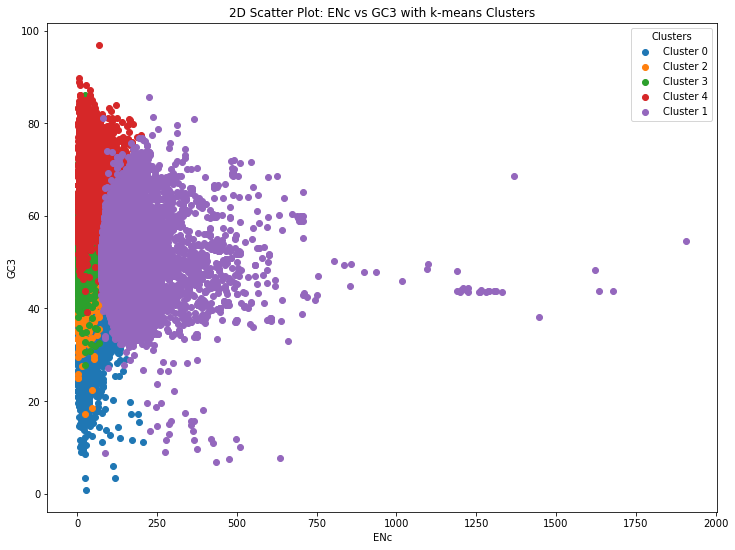

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

folder_path ="C:\\Users\\swapn\\Desktop\\Fasta Data"

all_combined_data = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        all_combined_data = pd.concat([all_combined_data, data])

# Features for clustering
features = ['ENc', 'GC1', 'GC2', 'GC3']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_combined_data[features])

# Perform k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
all_combined_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Plotting 2D Scatter Plot for all Organism Groups together based on k-means clusters
plt.figure(figsize=(12, 9))
for cluster_label in all_combined_data['Cluster'].unique():
    cluster_data = all_combined_data[all_combined_data['Cluster'] == cluster_label]
    plt.scatter(cluster_data['ENc'], cluster_data['GC3'], label=f'Cluster {cluster_label}')
plt.xlabel('ENc')
plt.ylabel('GC3')
plt.title('2D Scatter Plot: ENc vs GC3 with k-means Clusters')
plt.legend(title='Clusters')
plt.show()


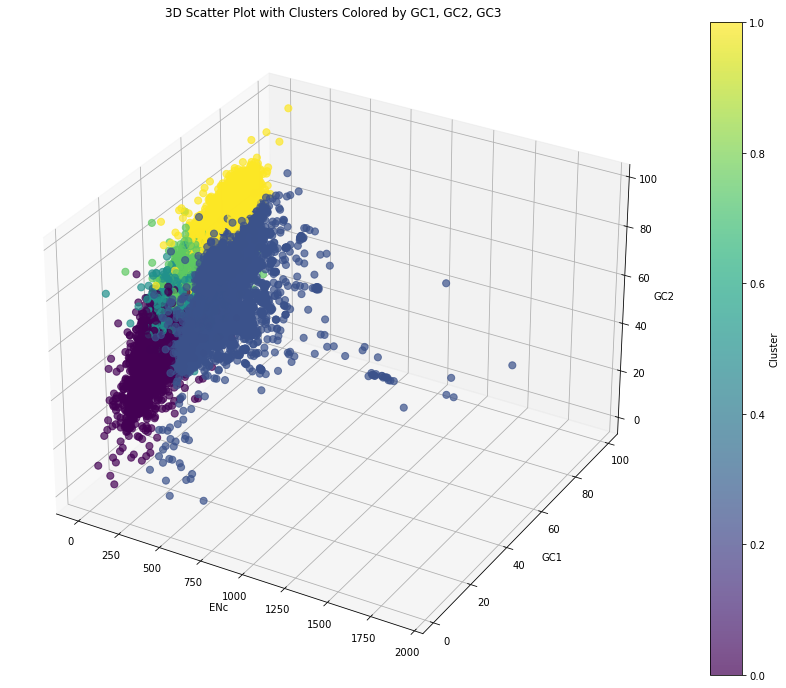

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler for color scaling

folder_path = "C:\\Users\\swapn\\Desktop\\Fasta Data"

all_combined_data = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        all_combined_data = pd.concat([all_combined_data, data])

# Features for clustering
features = ['ENc', 'GC1', 'GC2', 'GC3']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_combined_data[features])

# Perform k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
all_combined_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Set up color scaling
color_scaler = MinMaxScaler()
cluster_colors = color_scaler.fit_transform(all_combined_data['Cluster'].values.reshape(-1, 1))

# Plotting 3D Scatter Plot with clusters colored by 'GC1', 'GC2', and 'GC3'
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    all_combined_data['ENc'],
    all_combined_data['GC1'],
    all_combined_data['GC2'],
    c=cluster_colors.flatten(),  # Use cluster colors for color
    cmap='viridis',  # Colormap for better visualization
    s=50,  # Adjust point size
    alpha=0.7,  # Adjust transparency
)

ax.set_xlabel('ENc')
ax.set_ylabel('GC1')
ax.set_zlabel('GC2')
plt.title('3D Scatter Plot with Clusters Colored by GC1, GC2, GC3')

# Add color bar for better reference
color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label('Cluster')

plt.show()


# Applying PCA

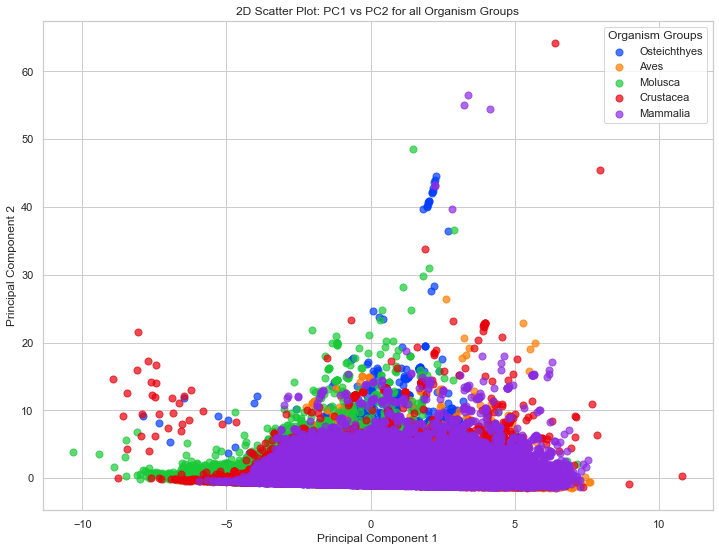

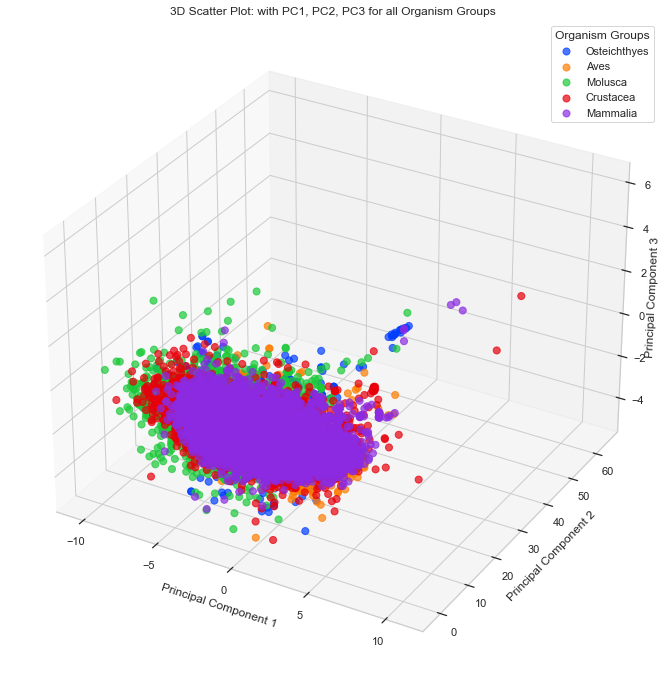

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

folder_path = "C:\\Users\\swapn\\Desktop\\Fasta Data"

all_combined_data = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        all_combined_data = pd.concat([all_combined_data, data])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_combined_data[['ENc', 'GC1', 'GC2', 'GC3']])

pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

all_combined_data['PC1'] = principal_components[:, 0]
all_combined_data['PC2'] = principal_components[:, 1]
all_combined_data['PC3'] = principal_components[:, 2]

bright_palette = sns.color_palette("bright", n_colors=len(all_combined_data['Organism Group'].unique()))

# 2D Scatter Plot
plt.figure(figsize=(12, 9))
sns.set(style="whitegrid", palette=bright_palette)
for group_name in all_combined_data['Organism Group'].unique():
    group_data = all_combined_data[all_combined_data['Organism Group'] == group_name]
    plt.scatter(group_data['PC1'], group_data['PC2'], label=f'{group_name}', s=50, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot: PC1 vs PC2 for all Organism Groups')
plt.legend(title='Organism Groups')
plt.savefig('2D_Scatter_Plot.png', dpi=300)
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')
ax.grid(True)

colors = [bright_palette[i] for i, _ in enumerate(all_combined_data['Organism Group'].unique())]

for idx, group_name in enumerate(all_combined_data['Organism Group'].unique()):
    group_data = all_combined_data[all_combined_data['Organism Group'] == group_name]
    ax.scatter(group_data['PC1'], group_data['PC2'], group_data['PC3'], label=f'{group_name}', s=50, alpha=0.7,
               color=colors[idx], marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3', labelpad=-3)
plt.title('3D Scatter Plot: with PC1, PC2, PC3 for all Organism Groups')
ax.legend(title='Organism Groups', loc='upper right')
plt.savefig('3D_Scatter_Plot.png', dpi=300)
plt.show()


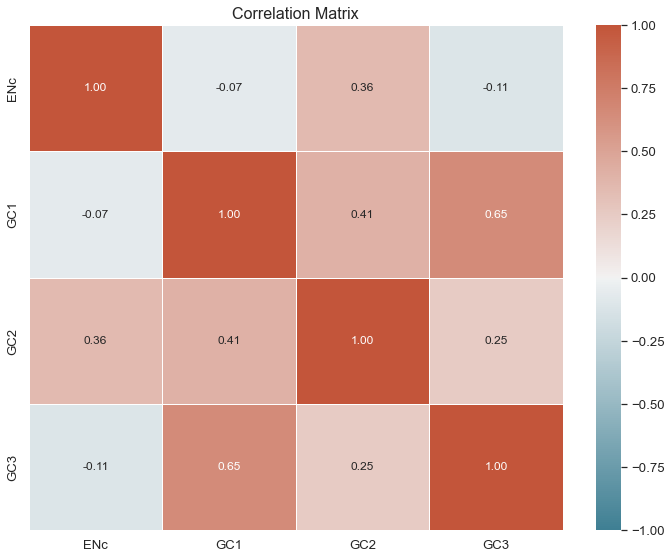

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

folder_path = "C:\\Users\\swapn\\Desktop\\Data Fasta"

all_combined_data = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)
        all_combined_data = pd.concat([all_combined_data, data])

# Normalize data 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_combined_data[['ENc', 'GC1', 'GC2', 'GC3']])

# Calculate the correlation matrix
correlation_matrix = all_combined_data[['ENc', 'GC1', 'GC2', 'GC3']].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) 
sns.set_style("whitegrid")

cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1,
            fmt='.2f', annot_kws={"size": 12}, linewidths=.5)

# Set title and adjust layout
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()
